# Examples for the use of SmallDataAna (peak on cs140)

In [2]:
%matplotlib notebook
%pylab
import sys
import time
sys.path.append('/reg/d/psdm/xpp/xpptut15/results/smalldata_tools/smalldata_tools')
import SmallDataAna as sda
from pscache import rerun

runNr=65
#runNr=153
liveList = ['fiducials','lightStatus/xray','lightStatus/laser','ipm2/sum','ipm3/sum','diodeU/channels','tt/ttCorr',\
            'tt/AMPL','cs140_rob/ROI_0_sum']
ana = sda.SmallDataAna('xpp12816',runNr, dirname='/reg/d/psdm/xpp/xpptut15/results/smalldata_tools/output/', \
                       intable='redis', liveList=liveList)
#ana = sda.SmallDataAna('xpp12816',runNr, dirname='/reg/d/psdm/xpp/xpptut15/results/smalldata_tools/output/')

nEvts_per_bin_average=65
scanVar=None
while scanVar is None:
    time.sleep(1)
    try:
        scanVar = ana.getScanName()
    except:
        pass
    
ana.addCut('lightStatus/xray',0.5,1.5,'on')
ana.addCut('lightStatus/laser',0.5,1.5,'on')
ana.addCut('lightStatus/xray',0.5,1.5,'off')
ana.addCut('lightStatus/laser',-0.5,0.5,'off')
    
if runNr==65:
    ana.addCut('ipm3/sum',0.02,10.,'on')
    ana.addCut('ipm3/sum',0.02,10.,'off')
if runNr==153:
    ana.addCut('ipm3/sum',0.03,10.,'on')
    ana.addCut('ipm3/sum',0.03,10.,'off')
ana.addCut('tt/AMPL',0.025,10.,'on')

ana.addToLive(['scan/%s'%scanVar])

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib
and now open in dir:  /reg/d/psdm/xpp/xpptut15/results/smalldata_tools/output/  to open file  /reg/d/psdm/xpp/xpptut15/results/smalldata_tools/output//xpp12816_Run065.h5


/reg/d/psdm/xpp/xpptut15/results/smalldata_tools/smalldata_tools/SmallDataAna.py:949: RuntimeWarning: invalid value encountered in greater
  filters.append((thisPlotvar > thiscut[1]) & (thisPlotvar < thiscut[2]))
/reg/d/psdm/xpp/xpptut15/results/smalldata_tools/smalldata_tools/SmallDataAna.py:949: RuntimeWarning: invalid value encountered in less
  filters.append((thisPlotvar > thiscut[1]) & (thisPlotvar < thiscut[2]))


In [ ]:
%rerun 10
#update xarray.
timeUpdate = time.time()
ana._updateXarray_fromREDIS()
nEvtsLive = ana.xrData[ana.xrData.keys()[0]].shape[0]
print 'took %f sec to update, now have %d events'%(time.time()-timeUpdate, nEvtsLive)
#print ana.xrData.keys()
#print '----------'

delay = ana.getDelay()
delayMin = np.percentile(delay,0.5)
delayMax = np.percentile(delay, 99.5)
    
nBin = ana.getFilter('on').sum()/nEvts_per_bin_average
bins = np.linspace(delayMin,delayMax,nBin)
nBinOff = ana.getFilter('off').sum()/nEvts_per_bin_average
binsOff = np.linspace(delayMin,delayMax,nBinOff)
print 'of %d events, %d/%d pass the on/off selection (%f/%f percent)'%(nEvtsLive,\
                                                                       ana.getFilter('on').sum(),ana.getFilter('off').sum(),\
                                                                       ana.getFilter('on').sum()*100./nEvtsLive,ana.getFilter('off').sum()*100./nEvtsLive)

ana.addCube('cube','delay',bins,'on')
ana.addToCube('cube',['ipm2/sum','ipm3/sum','diodeU/channels','cs140_rob/ROI_0_sum'])
ana.addCube('cubeOff','delay',binsOff,'off')
ana.addToCube('cubeOff',['ipm2/sum','ipm3/sum','diodeU/channels','cs140_rob/ROI_0_sum'])

cubeData = ana.makeCubeData('cube')
if len(binsOff)>3:
    cubeDataOff = ana.makeCubeData('cubeOff')
print "update tool total time of %s sec"%(time.time()-timeUpdate)

took 0.121153 sec to update, now have 14399 events
of 14399 events, 615/128 pass the on/off selection (4.271130/0.888951 percent)
update tool total time of 0.172383069992 sec


<IPython.core.display.Javascript object>


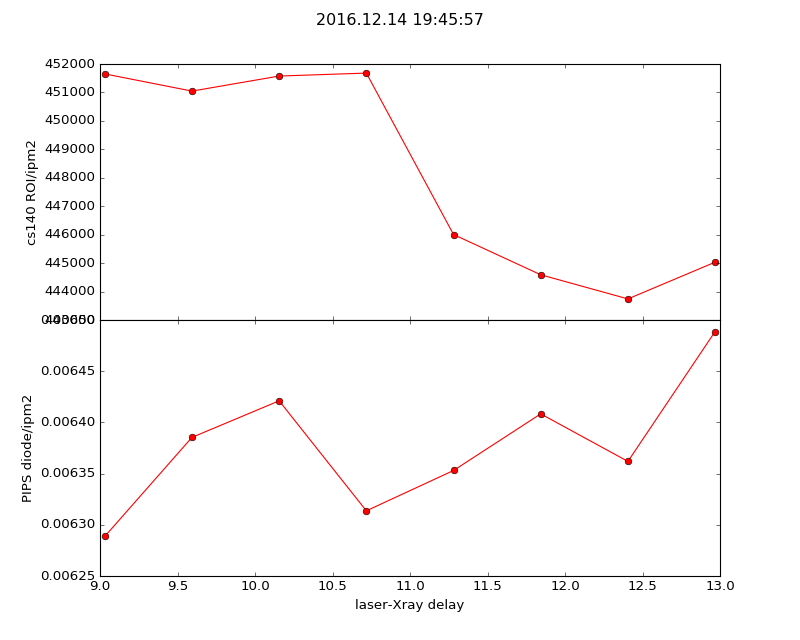

update tool total time of 0.278229951859 sec (incl plot)


In [28]:
%rerun 8
f,ax = plt.subplots(nrows=2,ncols=1,figsize=[10,8],sharex=True)
ax[0].plot(cubeData['binVar_bins'],cubeData['cs140_rob__ROI_0_sum']/cubeData['ipm2__sum'],'o-r')
ax[1].plot(cubeData['binVar_bins'],cubeData['diodeU__channels'][:,1]/cubeData['ipm2__sum'],'o-r')
try:
    ax[0].plot(cubeDataOff['binVar_bins'],cubeDataOff['cs140_rob__ROI_0_sum']/cubeDataOff['ipm2__sum'],'o-k')
    ax[1].plot(cubeDataOff['binVar_bins'],cubeDataOff['diodeU__channels'][:,1]/cubeDataOff['ipm2__sum'],'o-k')
except:
    pass
ax[1].set_xlabel('laser-Xray delay')
ax[0].set_ylabel('cs140 ROI/ipm2')
ax[1].set_ylabel('PIPS diode/ipm2')
timeStr = time.strftime("%Y.%m.%d %H:%M:%S", time.gmtime(max(ana._tStamp).astype(int)/1000000000))
st = f.suptitle(timeStr, fontsize="large")
f.subplots_adjust(hspace=0)
print "update tool total time of %s sec (incl plot)"%(time.time()-timeUpdate)

In [ ]:
print len(ana.getDelay())
print ana.getFilter('on').sum()
print ana.getFilter('off').sum()
plt.figure()
ana.plotVar('ipm3/sum')